# Redes Neuronales Recurrentes y Prophet para Predicción de Series Temporales (Core)

## Descripción:

En este ejercicio, implementarás una red neuronal recurrente (RNN) utilizando LSTM para predecir valores futuros en una serie temporal. Además, se te pide que explores el uso de la herramienta Prophet, un modelo de predicción de series temporales desarrollado por Facebook, y compares los resultados obtenidos con los de la RNN.

## Objetivo:

El objetivo es predecir los valores futuros de una serie temporal utilizando redes recurrentes y comparar su rendimiento con Prophet. Este ejercicio te permitirá explorar dos enfoques distintos para la predicción de series temporales.

## Instruccioens:

### 1. Selección del dataset:

* Utiliza un dataset de series temporales de Kaggle, como el de «Air Quality Prediction» o cualquier otro relacionado con predicción de demanda, precios de acciones, etc. Puedes elegir el dataset que más se relacione con tus intereses.
* Enlace sugerido: [Air Quality Prediction](https://www.kaggle.com/competitions/air-quality-prediction)

### 2. Preprocesamiento de datos:

* Realiza una exploración inicial de la serie temporal, incluyendo la visualización de la tendencia y la estacionalidad si es aplicable.
* Realiza un escalado de los datos, ya que las redes neuronales recurrentes se benefician de que los datos estén en un rango similar.

### 3. Implementación de RNN con LSTM:

* Implementa una red LSTM para predecir la serie temporal. Utiliza una arquitectura simple con una capa LSTM y una capa densa para predecir el valor futuro de la serie temporal.
* Asegúrate de dividir los datos en conjuntos de entrenamiento y prueba, utilizando las primeras partes de la serie para entrenar el modelo y las últimas partes para probar la precisión de las predicciones.

### 4. Uso de Prophet:

* Instala y utiliza Prophet para predecir la misma serie temporal. Prophet es un modelo que maneja fácilmente tendencias y estacionalidades, por lo que es ideal para comparación con redes recurrentes.
* Entrena Prophet con los mismos datos que utilizaste para la red LSTM y realiza predicciones en el conjunto de prueba.

### 5. Comparación de resultados:

* Compara las predicciones de la red LSTM con las predicciones de Prophet. Utiliza métricas como el RMSE (Root Mean Squared Error) o el MAE (Mean Absolute Error) para medir la precisión de ambos modelos.
* Visualiza las predicciones de ambos modelos superpuestas a la serie temporal original para ver cuál se ajusta mejor a los datos.

### 6. Análisis y discusión:

* Discute cuál de los modelos ofrece mejores resultados en este caso particular. ¿Por qué crees que Prophet o la red LSTM tuvieron un mejor rendimiento?
* Reflexiona sobre las ventajas y desventajas de cada enfoque para la predicción de series temporales.

# Resolución

## 1. Selección de Dataset

In [44]:
from utils.git_utils import get_repo_file_path
from utils.kaggle_utils import descargar_dataset_kaggle


# Asegúrarse de que el archivo kaggle.json con las credenciales de kaggle
# estén en el directorio base del repositorio.
kaggle_credentials_path = get_repo_file_path("kaggle.json")

descargar_dataset_kaggle(
    "https://www.kaggle.com/competitions/air-quality-prediction",
    kaggle_credentials_path,
    "../data/",
)

Skipping, found downloaded files in "../data/air-quality-prediction" (use force=True to force download)


## 2. Preprocesamiento de datos:

### Realiza una exploración inicial de la serie temporal, incluyendo la visualización de la tendencia y la estacionalidad si es aplicable.

In [45]:
import pandas as pd


camino_ds = "../data/air-quality-prediction/train.csv"
df = pd.read_csv(camino_ds)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   DEWP    41757 non-null  int64  
 2   TEMP    41757 non-null  float64
 3   PRES    41757 non-null  float64
 4   cbwd    41757 non-null  object 
 5   Iws     41757 non-null  float64
 6   Is      41757 non-null  int64  
 7   Ir      41757 non-null  int64  
 8   AQI     41757 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 2.9+ MB


In [46]:
df.head(10)

,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI
0,1,-16,-4.0,1020.0,SE,1.79,0,0,129
1,2,-15,-4.0,1020.0,SE,2.68,0,0,148
2,3,-11,-5.0,1021.0,SE,3.57,0,0,159
3,4,-7,-5.0,1022.0,SE,5.36,1,0,181
4,5,-7,-5.0,1022.0,SE,6.25,2,0,138
5,6,-7,-6.0,1022.0,SE,7.14,3,0,109
6,7,-7,-6.0,1023.0,SE,8.93,4,0,105
7,8,-7,-5.0,1024.0,SE,10.72,0,0,124
8,9,-8,-6.0,1024.0,SE,12.51,0,0,120
9,10,-7,-5.0,1025.0,SE,14.30,0,0,132


In [47]:
from utils.eda_utils import obtener_columnas_categoricas_df, limpiar_cadena

columnas_categoricas = obtener_columnas_categoricas_df(df)


for columna in columnas_categoricas:
    df[columna] = df[columna].apply(limpiar_cadena)

In [48]:
columnas_objeto_cadena = df.select_dtypes(include=["object", "string"]).columns.tolist()

In [49]:
# Se elige el 5% como valor para empezar a considerar una columna como categórica.
# Si se supera esta cantidad la columna se dejará como cadena.
porcentaje_max_columnas_categoricas = 0.05
cant_filas_df = df.shape[0]

columnas_a_excluir = []
columnas_convertidas_a_categoricas = []
columnas_convertidas_a_string = []

for columna in columnas_objeto_cadena:
    valores_unicos = df[columna].dropna().unique().tolist()
    print(f"Cant. únicos para columna '{columna}': {len(valores_unicos)}")
    if len(valores_unicos) <= (porcentaje_max_columnas_categoricas * cant_filas_df):
        
        print(f"Valores únicos columna '{columna}': {str(valores_unicos)}")
        print(f"Se procede a convertir la columna '{columna}' a categórica")
        df[columna] = df[columna].astype("category")
        columnas_convertidas_a_categoricas.append(columna)
    else:
        print(f"No se convierte la columna '{columna}' a categórica, se opta por dejarla como string")
        df[columna] = df[columna].astype("string")
        columnas_convertidas_a_string.append(columna)

    del valores_unicos

print("\n")
print(f"Cant. de columnas analizadas: {len(columnas_objeto_cadena)}")
print(f"Cant. de columnas convertidas a category: {len(columnas_convertidas_a_categoricas)}")
print(f"Cant. de columnas convertidas a string: {len(columnas_convertidas_a_string)}")
print(f"Columnas convertidas a categóricas: {str(columnas_convertidas_a_categoricas)}")
print(f"Columnas convertidas a string: {str(columnas_convertidas_a_string)}")

Cant. únicos para columna 'cbwd': 4
Valores únicos columna 'cbwd': ['se', 'cv', 'nw', 'ne']
Se procede a convertir la columna 'cbwd' a categórica


Cant. de columnas analizadas: 1
Cant. de columnas convertidas a category: 1
Cant. de columnas convertidas a string: 0
Columnas convertidas a categóricas: ['cbwd']
Columnas convertidas a string: []


### Realiza una exploración inicial de la serie temporal, incluyendo la visualización de la tendencia y la estacionalidad si es aplicable.

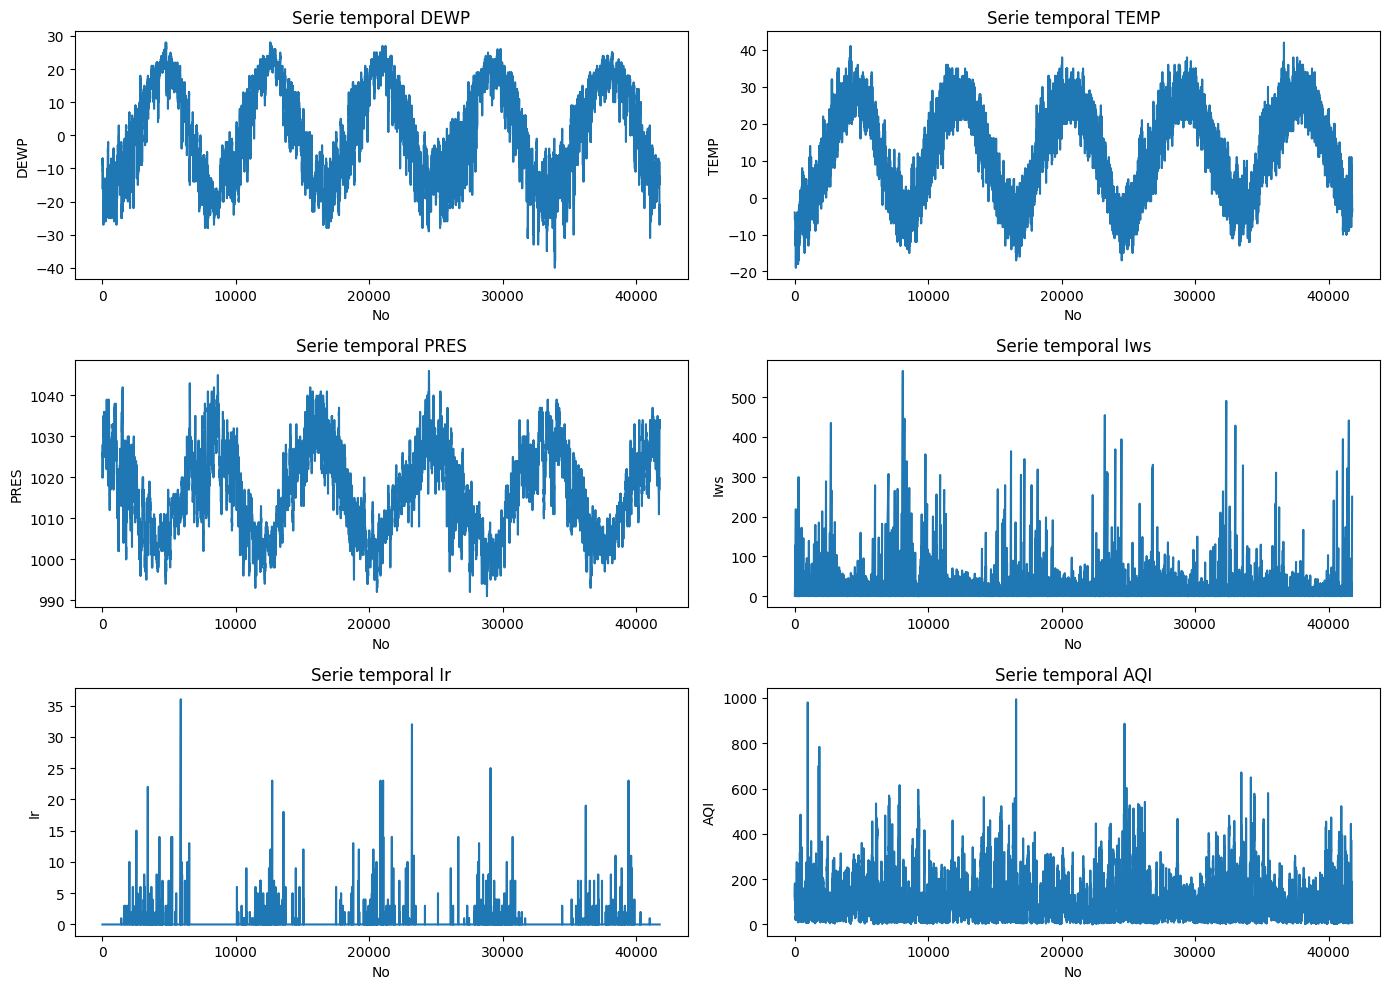

In [50]:
from utils.eda_utils import graficar_series_temporales


graficar_series_temporales(df, ["DEWP", "TEMP", "PRES", "Iws", "Ir", "AQI"], "No", 2)

### Realiza un escalado de los datos, ya que las redes neuronales recurrentes se benefician de que los datos estén en un rango similar.

In [116]:
columnas_prediccion = df.columns.tolist()
columnas_prediccion.remove("AQI")
columnas_prediccion.remove("No")


Importamos las librerías necesarias

In [219]:
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from utils.eda_utils import obtener_columnas_numericas_df

from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

In [75]:
columnas_numericas_a_escalar = obtener_columnas_numericas_df(df)
columnas_numericas_a_escalar.remove("AQI")
columnas_numericas_a_escalar.remove("No")

In [78]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler((0, 1)), columnas_numericas_a_escalar),
        ("onehot", OneHotEncoder(), ["cbwd",]),
    ],
    remainder="passthrough"
)

In [79]:
X_transf = preprocessor.fit_transform(X)

df_transf = pd.DataFrame(X_transf, columns=preprocessor.get_feature_names_out())

df_transf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num__DEWP        41757 non-null  float64
 1   num__TEMP        41757 non-null  float64
 2   num__PRES        41757 non-null  float64
 3   num__Iws         41757 non-null  float64
 4   num__Is          41757 non-null  float64
 5   num__Ir          41757 non-null  float64
 6   onehot__cbwd_cv  41757 non-null  float64
 7   onehot__cbwd_ne  41757 non-null  float64
 8   onehot__cbwd_nw  41757 non-null  float64
 9   onehot__cbwd_se  41757 non-null  float64
dtypes: float64(10)
memory usage: 3.2 MB


In [81]:
df_transf.describe().T

,count,mean,std,min,25%,50%,75%,max
num__DEWP,41757.0,0.613973,0.212260,0.0,0.441176,0.617647,0.808824,1.0
num__TEMP,41757.0,0.514780,0.199594,0.0,0.344262,0.540984,0.688525,1.0
num__PRES,41757.0,0.462598,0.187286,0.0,0.309091,0.454545,0.618182,1.0
num__Iws,41757.0,0.041443,0.087812,0.0,0.002372,0.008707,0.037980,1.0
num__Is,41757.0,0.002050,0.028847,0.0,0.000000,0.000000,0.000000,1.0
num__Ir,41757.0,0.005413,0.039393,0.0,0.000000,0.000000,0.000000,1.0
onehot__cbwd_cv,41757.0,0.214192,0.410265,0.0,0.000000,0.000000,0.000000,1.0
onehot__cbwd_ne,41757.0,0.113897,0.317690,0.0,0.000000,0.000000,0.000000,1.0
onehot__cbwd_nw,41757.0,0.322916,0.467596,0.0,0.000000,0.000000,1.000000,1.0
onehot__cbwd_se,41757.0,0.348995,0.476658,0.0,0.000000,0.000000,1.000000,1.0


## 3. Implementación de RNN con LSTM:

### Asegúrate de dividir los datos en conjuntos de entrenamiento y prueba, utilizando las primeras partes de la serie para entrenar el modelo y las últimas partes para probar la precisión de las predicciones.

Se separará el dataset en 70% de entrenamiento y 30% para prueba. Esto se realizará encontrando el índice de separación del 70% inicial de los datos. Esto se hace así ya que al ser un dataset de tipo serie, se deben predecir los valores futuros, no valores aleatorios, como ocurriría si se usa train_test_split

In [246]:
import numpy as np

def split_multivariate_sequence(sequence, n_steps_in, n_steps_out):
    """
    Split a multivariate sequence into samples.

    Parameters:
        sequence (ndarray): Multivariate time-series data of shape (timesteps, features).
        n_steps_in (int): Number of input timesteps.
        n_steps_out (int): Number of output timesteps.

    Returns:
        X (ndarray): Input samples of shape (samples, n_steps_in, features).
        y (ndarray): Output samples of shape (samples, n_steps_out, features).
    """
    X, y = [], []
    for i in range(len(sequence)):
        # Find the end of the current input sequence
        end_ix = i + n_steps_in
        # Find the end of the current output sequence
        out_end_ix = end_ix + n_steps_out
        
        # Break if the end index exceeds the dataset length
        if out_end_ix > len(sequence):
            break
        
        # Slice the input and output sequences
        seq_x = sequence[i:end_ix, :]
        seq_y = sequence[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)


inputs = df[columnas_prediccion]
inputs_scaled = preprocessor.fit_transform(inputs)

outputs = df[["AQI"]].values

data = np.append(inputs_scaled, outputs, axis=1)

n_steps_in = 1
n_steps_out = 1
X, y = split_multivariate_sequence(data, n_steps_in, n_steps_out)

In [248]:
print(X.shape)
print(y.shape)

(41756, 1, 11)
(41756, 1)


In [237]:
indice_separacion = split_index = int(len(df) * 0.7)

X_train = X[:indice_separacion]
X_test = X[indice_separacion:]
y_train = y[:indice_separacion]
y_test = y[indice_separacion:]

### Implementa una red LSTM para predecir la serie temporal. Utiliza una arquitectura simple con una capa LSTM y una capa densa para predecir el valor futuro de la serie temporal.

In [238]:
# Definir el callback de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [256]:
# Crear el modelo LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, 11)),
    Dense(1)  # Output one value for regression
])


model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 50)             │        12,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,451 (48.64 KB)

 Trainable params: 12,451 (48.64 KB)

 Non-trainable params: 0 (0.00 B)

In [257]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks=[early_stopping],
)

Epoch 1/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 64.6029 - val_loss: 38.9065
Epoch 2/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 36.6232 - val_loss: 24.1873
Epoch 3/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 24.0565 - val_loss: 19.8918
Epoch 4/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 21.8184 - val_loss: 14.8813
Epoch 5/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 17.1799 - val_loss: 13.5782
Epoch 6/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 15.4892 - val_loss: 13.5779
Epoch 7/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 15.3524 - val_loss: 13.6674
Epoch 8/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 21.9074 - val_loss: 21.7574
Epoch 9/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 22.5402 - val_loss: 22.6214
Epoch 10/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 20.4102 - val_loss: 22.5508
Epoch 11/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 19.4416 - val_loss: 13.3674
Epoch 12/50
914/914 ━━━━━━━━━

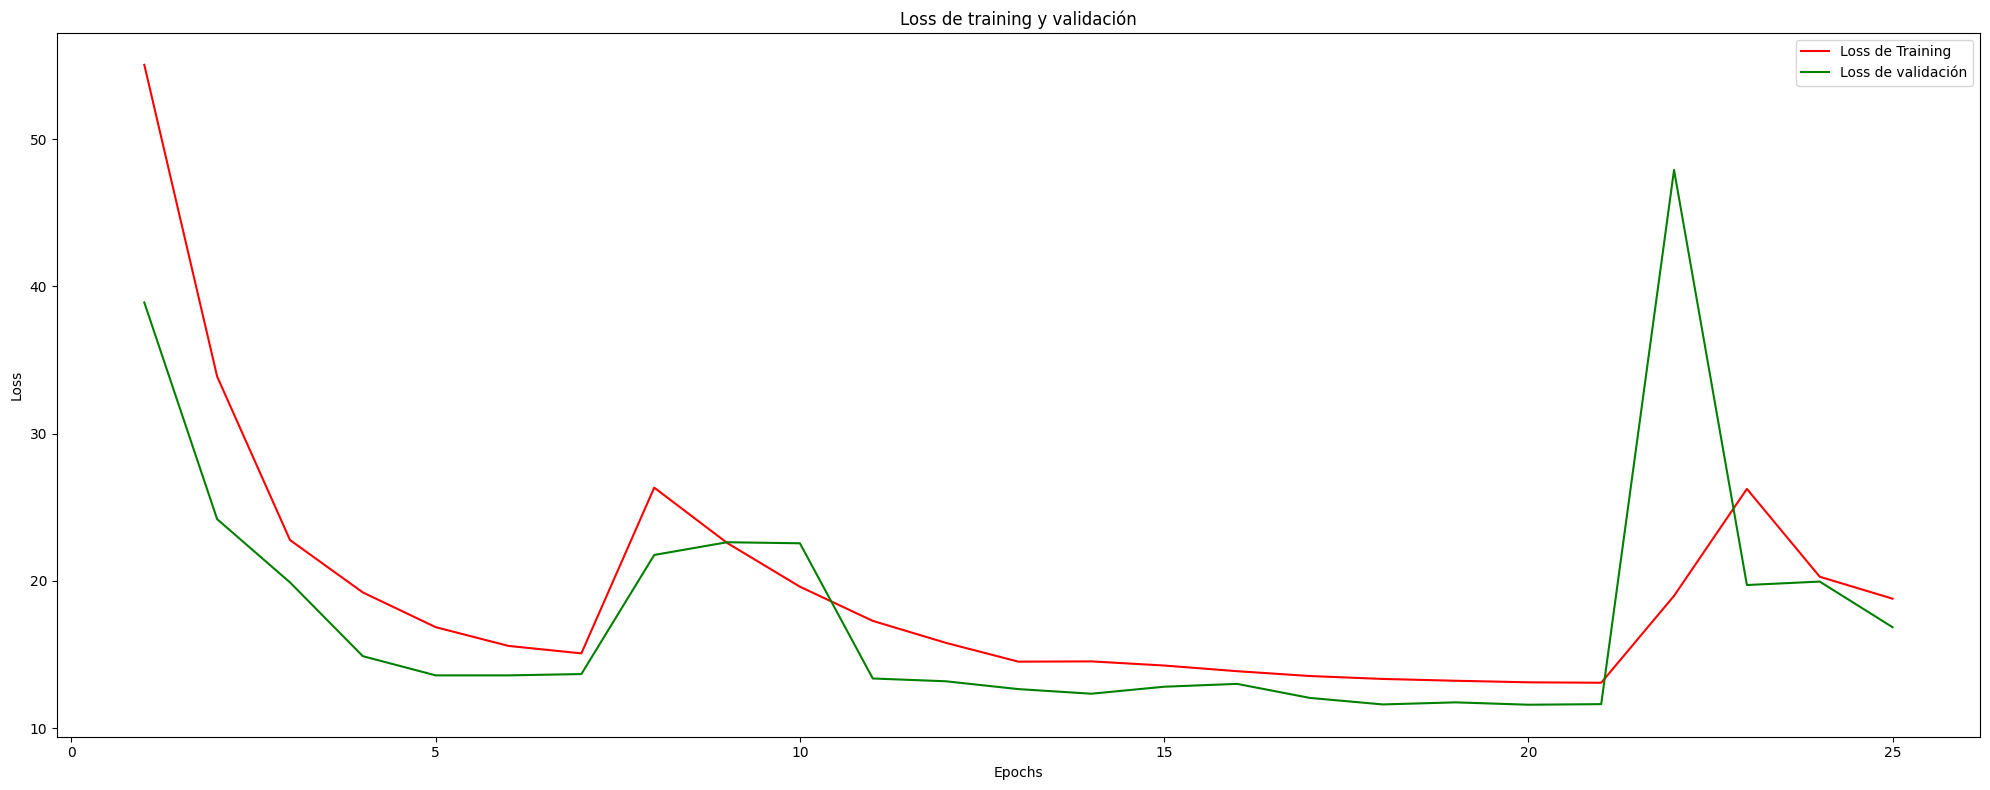

In [258]:
tr_loss = history.history['loss']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

epochs = [i+1 for i in range(len(tr_loss))]

# Gráfico
plt.figure(figsize= (20, 8))

plt.plot(epochs, tr_loss, 'r', label= 'Loss de Training')
plt.plot(epochs, val_loss, 'g', label= 'Loss de validación')
plt.title('Loss de training y validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [259]:
rango_aqi = df["AQI"].max()-df["AQI"].min()
porcentaje_error = (val_lowest / rango_aqi) * 100

print(f"Rango AQI: {rango_aqi}")
print(f"Porcentaje Error: {porcentaje_error:.2f}%")

Rango AQI: 994
Porcentaje Error: 1.17%


Como podemos notar, el error calculado en pruebas es bastante bajo, lo que indica que el modelo funciona predice los datos a futuro correctamente.

## 4. Uso de Prophet:

### Instala y utiliza Prophet para predecir la misma serie temporal. Prophet es un modelo que maneja fácilmente tendencias y estacionalidades, por lo que es ideal para comparación con redes recurrentes.

### Entrena Prophet con los mismos datos que utilizaste para la red LSTM y realiza predicciones en el conjunto de prueba.

In [ ]:
from prophet import Prophet

/home/diego/.virtualenvs/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Como prophet requiere de una fecha, se simula una fecha incremental de 1 minuto. Esto no debería realizarse de esta manera, pero se implementa así a efectos de resolver el ejercicio.

In [209]:
from datetime import timedelta

df_copy = df.copy()
df_copy.rename(columns={'AQI': 'y'}, inplace=True)

df_copy['ds'] = pd.date_range(start='2024-01-01', periods=len(df_copy), freq=timedelta(minutes=1))

df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   No      41757 non-null  int64         
 1   DEWP    41757 non-null  int64         
 2   TEMP    41757 non-null  float64       
 3   PRES    41757 non-null  float64       
 4   cbwd    41757 non-null  category      
 5   Iws     41757 non-null  float64       
 6   Is      41757 non-null  int64         
 7   Ir      41757 non-null  int64         
 8   y       41757 non-null  int64         
 9   ds      41757 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(3), int64(5)
memory usage: 2.9 MB


In [210]:
indice_separacion = split_index = int(len(df_copy) * 0.7)

df_copy_train = df_copy.iloc[:indice_separacion]
df_copy_test = df_copy.iloc[indice_separacion:]

In [211]:
df_copy.columns.tolist()

['No', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir', 'y', 'ds']

In [214]:
prophet_model = Prophet(interval_width=1.0)
prophet_model.add_regressor('DEWP')
prophet_model.add_regressor('TEMP')
prophet_model.add_regressor('PRES')
# No se usa la columna cbwd ya que es categórica
# prophet_model.add_regressor('cbwd')
prophet_model.add_regressor('Iws')
prophet_model.add_regressor('Is')
prophet_model.add_regressor('Ir')

In [215]:
prophet_model.fit(df_copy_train)

02:59:44 - cmdstanpy - INFO - Chain [1] start processing
03:00:08 - cmdstanpy - INFO - Chain [1] done processing


In [218]:
prophet_model.predict(df_copy_test)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2024-01-21 07:09:00,46.738711,-186.058956,298.167164
1,2024-01-21 07:10:00,46.643659,-185.006847,225.009873
2,2024-01-21 07:11:00,36.116475,-243.913153,308.490767
3,2024-01-21 07:12:00,41.629339,-161.917162,280.632356
4,2024-01-21 07:13:00,41.045286,-178.062497,272.114269
...,...,...,...,...
12523,2024-01-29 23:52:00,-834.624124,-8234.127806,5655.640444
12524,2024-01-29 23:53:00,-825.039835,-8018.822232,5593.459931
12525,2024-01-29 23:54:00,-825.573893,-8175.276981,5695.125252
12526,2024-01-29 23:55:00,-824.314918,-8151.012536,5733.822222


## 5. Comparación de resultados:

### Compara las predicciones de la red LSTM con las predicciones de Prophet. Utiliza métricas como el RMSE (Root Mean Squared Error) o el MAE (Mean Absolute Error) para medir la precisión de ambos modelos.

In [260]:
y_test

array([[18.],
       [22.],
       [24.],
       ...,
       [10.],
       [ 8.],
       [12.]])

In [261]:
# Realizar predicciones
y_pred_lstm = model.predict(X_test)

# Evaluar el modelo
rmse_lstm = root_mean_squared_error(y_test, y_pred_lstm)
mse_lstm = rmse_lstm ** 2
r2_lstm = r2_score(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print(f'Error Cuadrático Medio LSTM: {mse_lstm}')
print(f'Error Cuadrático Medio Raíz LSTM: {rmse_lstm}')
print(f'R-cuadrado LSTM: {r2_lstm}')
print(f'Error Absoluto Medio LSTM: {mae_lstm}')

391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Error Cuadrático Medio LSTM: 435.5170935088916
Error Cuadrático Medio Raíz LSTM: 20.869046300894816
R-cuadrado LSTM: 0.9469720308592092
Error Absoluto Medio LSTM: 11.584102130046862


In [268]:
# Realizar predicciones
y_pred_prophet = prophet_model.predict(df_copy_test)["yhat"]

# Evaluar el modelo
rmse_prophet = root_mean_squared_error(df_copy_test["y"], y_pred_prophet)
mse_prophet = rmse_lstm ** 2
r2_prophet = r2_score(df_copy_test["y"], y_pred_prophet)
mae_prophet = mean_absolute_error(df_copy_test["y"], y_pred_prophet)

print(f'Error Cuadrático Medio LSTM: {mse_prophet}')
print(f'Error Cuadrático Medio Raíz LSTM: {rmse_prophet}')
print(f'R-cuadrado LSTM: {r2_prophet}')
print(f'Error Absoluto Medio LSTM: {mae_prophet}')

Error Cuadrático Medio LSTM: 435.5170935088916
Error Cuadrático Medio Raíz LSTM: 421.79697472812626
R-cuadrado LSTM: -20.708415463119643
Error Absoluto Medio LSTM: 363.0096438499199


### Visualiza las predicciones de ambos modelos superpuestas a la serie temporal original para ver cuál se ajusta mejor a los datos.

#### LSTM

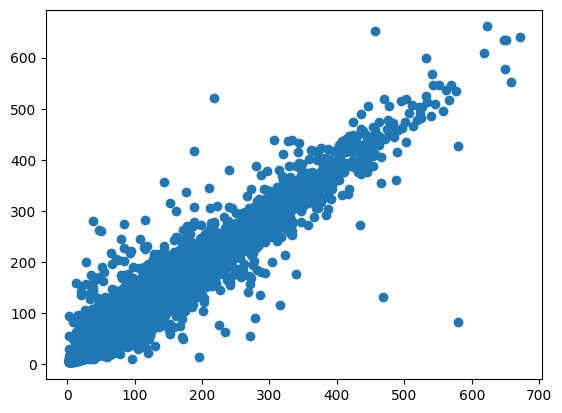

In [ ]:
plt.scatter(y_test.flatten(), y_pred_lstm.flatten())
plt.show()

#### Prophet

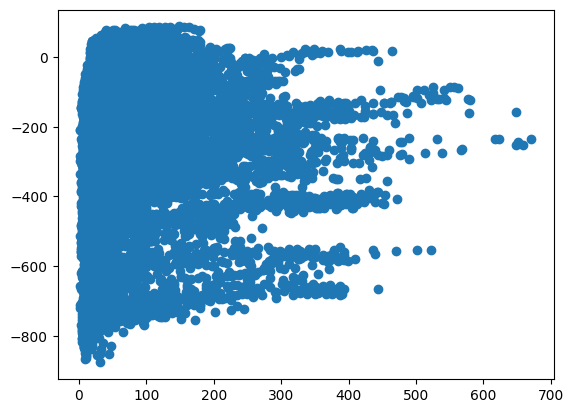

In [272]:
plt.scatter(df_copy_test["y"], y_pred_prophet)
plt.show()

## 6. Análisis y discusión:

### Discute cuál de los modelos ofrece mejores resultados en este caso particular. ¿Por qué crees que Prophet o la red LSTM tuvieron un mejor rendimiento?

De los resultados podemos notar lo siguiente:
* En todas las métricas, R2, MAE, MSE, RMSE, el modelo LSTM obtiene muy buenos resultados
* En el caso de Prophet, las métricas R2, MAE, MSE, RMSE no proporcionan buenos resultados. Esto se puede deber a que se agregó la columna ds artificialmente para probar el modelo Prophet. Como este no es el escenario en el que prophet funcionaría mejor, las predicciones no son correctas.

Por estos motivos, el mejor modelo para esta tarea de prediccion de series temporales es el LSTM.

### Reflexiona sobre las ventajas y desventajas de cada enfoque para la predicción de series temporales.

La gran ventaja que tiene prophet respecto a LSTM, es que es más sencillo de implementar, ya que provee una API muy sencilla. Por el contrario, el modelo LSTM hecho con Keras requiere de muchos pasos como: escalamiento, codificación de variables categóricas, creación de secuencias, entre otros.